# Introduction to Machine Learning (classification and regression)
### myChEMBL team, ChEMBL group, EMBL-EBI.

This tutorial is based on the great notebook by Nikolas Fechner and Greg Landrum [1]. In addition, there is a demonstration of a regression model trained on a ChEMBL data set. The notebook also uses code snippets from a notebook by Isidro Cortés Ciriano [2]. The interested reader is referred to these notebooks for further information. 


1 : http://nbviewer.ipython.org/gist/greglandrum/4316463

2 : http://nbviewer.ipython.org/github/BenderGroup/IPythonNotebooks/blob/master/Isidro_RDKit_Introduction/RDkit_Introduction.ipynb?create=1 

# Helper methods

In [1]:
%matplotlib inline
%pylab inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.metrics.metrics import classification_report, confusion_matrix, roc_curve,auc,accuracy_score

def confusion_matrix_summary(acts,preds):
    from cStringIO import StringIO
    file_str = StringIO()
    vTab=confusion_matrix(acts,preds)
    #print vTab
    nResultCodes=len(vTab)
    file_str.write('\n\tResults Table (experiment in rows):\n')
    colCounts = numpy.sum(vTab,0)
    rowCounts = numpy.sum(vTab,1)
    print
    for i in range(nResultCodes):
        if rowCounts[i]==0: rowCounts[i]=1
        row = vTab[i]
        file_str.write('    ')
        for j in range(nResultCodes):
            entry = row[j]
            file_str.write(' % 6d'%entry),
        file_str.write('     | % 4.2f\n'%(100.*vTab[i,i]/rowCounts[i]))
    file_str.write('    ')
    for i in range(nResultCodes):
        file_str.write('-------')
    file_str.write('\n')
    file_str.write('    '),
    for i in range(nResultCodes):
        if colCounts[i]==0: colCounts[i]=1
        file_str.write(' % 6.2f'%(100.*vTab[i,i]/colCounts[i])),
    file_str.write('\n')
    return file_str.getvalue()

def createROCPlot(pl,observations,probabilities,caption):
    fpr, tpr, thresholds = roc_curve(observations, probabilities)
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.set_xlim([0.0, 1.0])
    pl.set_ylim([0.0, 1.0])
    pl.set_xlabel('False Positive Rate')
    pl.set_ylabel('True Positive Rate')
    pl.set_title(caption)
    
def createPropAccPlot(pl,observations,probabilities,caption):
    fpr, tpr, thresholds = roc_curve(observations, probabilities)
    accuracies = []
    for t in thresholds:
        
        predictions = [1 if p >= t else 0 for p in probabilities]
        acc = accuracy_score(observations,predictions)
        accuracies.append(acc)
    pl.plot(thresholds, accuracies, label='Prob. vs Accuracy curve')
    pl.plot([0, 1], [0, 1], 'k--')
    pl.set_xlim([0.0, 1.0])
    pl.set_ylim([0.0, 1.0])
    pl.set_xlabel('Probability threshold')
    pl.set_ylabel('Accuracy')
    pl.set_title(caption)

def createImportancePlot(splt,desc,importances,caption):
    #plt.xkcd()
    import numpy.numarray as na    
    labels = []
    weights = []
    threshold = sort([abs(w) for w in importances])[-11]
    for d in zip(desc,importances):
        if abs(d[1]) > threshold:
            labels.append(d[0])
            weights.append(d[1])
    
    xlocations = na.array(range(len(labels)))+0.5
    width = 0.8
    splt.bar(xlocations, weights, width=width)
    splt.set_xticks([r+1 for r in range(len(labels))])
    splt.set_xticklabels(labels, rotation='vertical')
    splt.set_xlim(0, xlocations[-1]+width*2)
    splt.set_title(caption)
    splt.get_xaxis().tick_bottom()
    splt.get_yaxis().tick_left()

Populating the interactive namespace from numpy and matplotlib


# Dataset

Publicly available binary Ames test (mutagenicity) data compiled in "Benchmark Data Set for in Silico Prediction of Ames Mutagenicity", Katja Hansen et al., JCIM, 2009, 49(9),pp 2077-2081

Data available from http://doc.ml.tu-berlin.de/toxbenchmark/smiles_cas_N6512.smi

In [2]:
#location of datafiles
!pwd

/home/chembl/ipynb_workbench


In [3]:
from rdkit import Chem
import csv
#obtained from http://doc.ml.tu-berlin.de/toxbenchmark/smiles_cas_N6512.smi
with open('smiles_cas_N6512.smi','rU') as train_file:
    r = csv.reader(train_file, delimiter='\t')
    r.next()
    molecules = []
    observations = []
    for row in r:
        try:
         temp = Chem.MolFromSmiles(row[0])        
        except e:
            print e,row
            continue
        molecules.append(temp)
        observations.append(int(row[2]))
#molecules = [Chem.MolFromSmiles(d[0]) for d in row]
#observations = [int(d[2]) for d in raw]
data = [(x,y) for x,y in zip(molecules,observations) if x is not None]


# Fingerprint calculation

In [4]:
from rdkit.Chem import AllChem
import random

ind = range(len(data))
random.seed(0)
random.shuffle(ind)
half = int(round(0.5*len(ind)))
train = ind[:half]
test = ind[half:]

train_morgan_fps = []
train_rd_fps = []
train_ys = []
train_info=[]
test_info=[]

for i in train:
    mol = data[i][0]
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    train_morgan_fps.append(temp)
    train_info.append(info)
    train_rd_fps.append(Chem.RDKFingerprint(mol))
    train_ys.append(int(data[i][1]))
    
test_morgan_fps = []
test_rd_fps = []
test_ys = []
    
for i in test:
    mol = data[i][0]
    info = {}
    temp = AllChem.GetMorganFingerprintAsBitVect(mol,2,2048,bitInfo=info)
    test_morgan_fps.append(temp)
    test_info.append(info)
    test_rd_fps.append(Chem.RDKFingerprint(mol))
    test_ys.append(int(data[i][1]))
    
#import cPickle
#outf=file('fps.pkl','wb+')
#cPickle.dump((train,train_morgan_fps,train_info,train_rd_fps,train_ys),outf)
#cPickle.dump((test,test_morgan_fps,test_info,test_rd_fps,test_ys),outf)


Writing out the data can be a bit lengthy (especially on the virtual machine), hence the written file is provided in mychembl and the text is commented out. When uncommenting, please give the script some time before continuing. If an error occurs below 'EOF: ' this means the writing was not completed. Try these two sections again in this case. 

In [5]:
import cPickle
inf=file('fps.pkl','rb+')
(train,train_morgan_fps,train_info,train_rd_fps,train_ys)=cPickle.load(inf)
(test,test_morgan_fps,test_info,test_rd_fps,test_ys)=cPickle.load(inf)

# Binary Classification

### Naive Bayes

In [6]:
from sklearn.naive_bayes import BernoulliNB
morgan_bnb = BernoulliNB(fit_prior=False)
morgan_bnb.fit(train_morgan_fps,train_ys)
morgan_predictions = morgan_bnb.predict(test_morgan_fps)
print 'Morgan Fingerprints'
print confusion_matrix_summary(test_ys,morgan_predictions)
print classification_report(test_ys,morgan_predictions)


print '------------------------------------------------------------'
print 'RDKit Fingerprints'
rd_bnb = BernoulliNB(fit_prior=False)
rd_bnb.fit(train_rd_fps,train_ys)
rd_predictions = rd_bnb.predict(test_rd_fps)
print confusion_matrix_summary(test_ys,rd_predictions)
print classification_report(test_ys,rd_predictions)

morgan_probabilities = [p[1] for p in morgan_bnb.predict_proba(test_morgan_fps)]
rd_probabilities = [p[1] for p in rd_bnb.predict_proba(test_rd_fps)]

Morgan Fingerprints


	Results Table (experiment in rows):
       1153    332     |  77.64
        548   1219     |  68.99
    --------------
      67.78  78.59

             precision    recall  f1-score   support

          0       0.68      0.78      0.72      1485
          1       0.79      0.69      0.73      1767

avg / total       0.74      0.73      0.73      3252

------------------------------------------------------------
RDKit Fingerprints


	Results Table (experiment in rows):
       1012    473     |  68.15
        750   1017     |  57.56
    --------------
      57.43  68.26

             precision    recall  f1-score   support

          0       0.57      0.68      0.62      1485
          1       0.68      0.58      0.62      1767

avg / total       0.63      0.62      0.62      3252



Area under the ROC curve : 0.791817
Area under the ROC curve : 0.669390


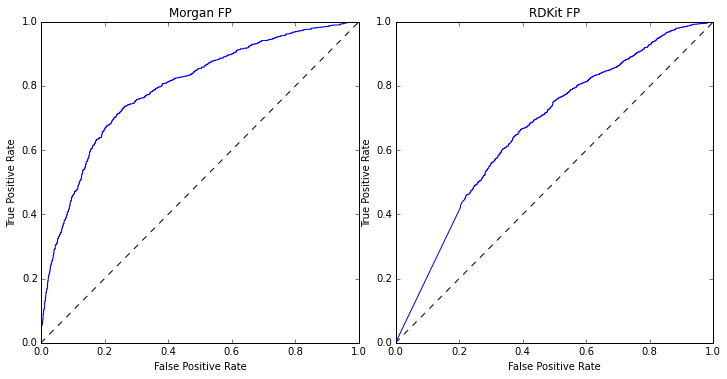

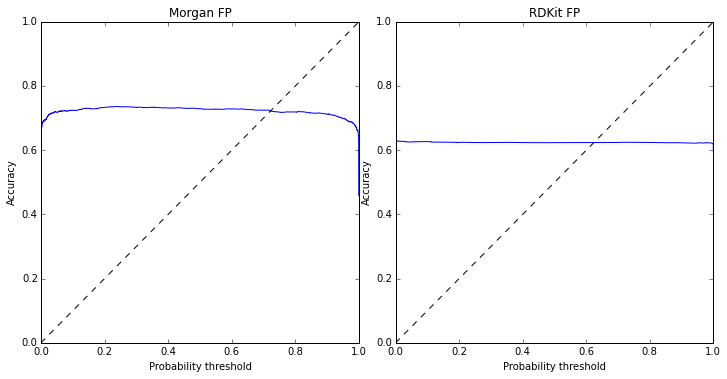

In [7]:
figure,(plt1,plt2) = pyplot.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createROCPlot(plt1,test_ys,morgan_probabilities,'Morgan FP')
createROCPlot(plt2,test_ys,rd_probabilities,'RDKit FP')

figure,(plt1,plt2) = pyplot.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createPropAccPlot(plt1,test_ys,morgan_probabilities,'Morgan FP')
createPropAccPlot(plt2,test_ys,rd_probabilities,'RDKit FP')



#### Obtain bit probabilities for later analysis

In [8]:
bit_probabilities = morgan_bnb.feature_log_prob_
position = []
enrichment = []
for d in zip(range(len(bit_probabilities[1])),[(w[0]-w[1]) for w in zip(bit_probabilities[0],bit_probabilities[1])]):
    if abs(d[1]) >= 1: #one log-level probablity difference between classes
        position.append(d[0])
        enrichment.append(d[1])
 

#### Binary classification is obtained by mapping selecting the most likely class 

In [9]:
#as implemented in sklearn
check_predictions = [1 if t[1] >= t[0] else 0 for t in morgan_bnb.predict_proba(test_morgan_fps)]
print confusion_matrix_summary(test_ys,check_predictions)

#equivalent for binary classification
check_predictions = [1 if p >= 0.5 else 0 for p in [t[1] for t in morgan_bnb.predict_proba(test_morgan_fps)]]
print confusion_matrix_summary(test_ys,check_predictions)




	Results Table (experiment in rows):
       1153    332     |  77.64
        548   1219     |  68.99
    --------------
      67.78  78.59



	Results Table (experiment in rows):
       1153    332     |  77.64
        548   1219     |  68.99
    --------------
      67.78  78.59



### Random Forests

Note, depending on your hardware this can take up to 30 minutes. 

In [10]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#params = {'max_depth':[2,5,10,20],'min_samples_split':[2,8,32,128],'min_samples_leaf':[1,2,5,10],'compute_importances':[True],'n_estimators':[200]}
#grid search is very timeconsuming, ~3hrs
params = {'compute_importances': [True], 'min_samples_split': [8], 'max_depth': [20], 'min_samples_leaf': [1],'n_estimators':[200]}
cv = KFold(n=len(train),n_folds=10,shuffle=True)
gs = GridSearchCV(RandomForestClassifier(), params, cv=cv,verbose=1,refit=True)
gs.fit(train_morgan_fps, train_ys)

#print 'Best score: %0.2f'%gs.best_score_
#print 'Training set performance using best parameters (%s)'%gs.best_params_
best_morgan_treemodel = gs.best_estimator_
#training set evaluation
best_morgan_tree_prediction = best_morgan_treemodel.predict(test_morgan_fps)
print 'Morgan Fingerprints'
print confusion_matrix_summary(test_ys,best_morgan_tree_prediction)
print classification_report(test_ys,best_morgan_tree_prediction)

print '------------------------------------------------------------'
gs.fit(train_rd_fps, train_ys)
#print 'Best score: %0.2f'%gs.best_score_
#print 'Training set performance using best parameters (%s)'%gs.best_params_
best_rd_treemodel = gs.best_estimator_
#training set evaluation
best_rd_tree_prediction = best_rd_treemodel.predict(test_rd_fps)
print 'RDKit Fingerprints'
print confusion_matrix_summary(test_ys,best_rd_tree_prediction)
print classification_report(test_ys,best_rd_tree_prediction)


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   33.6s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.6min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Morgan Fingerprints

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   33.4s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.5min finished





	Results Table (experiment in rows):
       1199    286     |  80.74
        458   1309     |  74.08
    --------------
      72.36  82.07

             precision    recall  f1-score   support

          0       0.72      0.81      0.76      1485
          1       0.82      0.74      0.78      1767

avg / total       0.78      0.77      0.77      3252

------------------------------------------------------------
Fitting 10 folds for each of 1 candidates, totalling 10 fits
RDKit Fingerprints


	Results Table (experiment in rows):
       1184    301     |  79.73
        360   1407     |  79.63
    --------------
      76.68  82.38

             precision    recall  f1-score   support

          0       0.77      0.80      0.78      1485
          1       0.82      0.80      0.81      1767

avg / total       0.80      0.80      0.80      3252



#### Probabilities can be obtained as proportion of the trees that predict the respective class

Area under the ROC curve : 0.845492
Area under the ROC curve : 0.865118


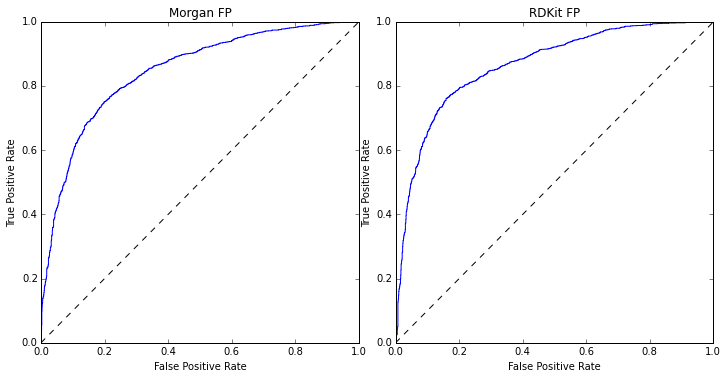

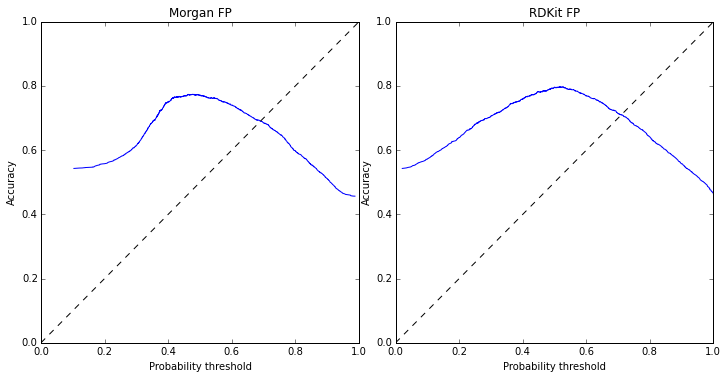

In [11]:
morgan_probabilities = [p[1] for p in best_morgan_treemodel.predict_proba(test_morgan_fps)]
rd_probabilities = [p[1] for p in best_rd_treemodel.predict_proba(test_rd_fps)]
figure,(plt1,plt2) = pyplot.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createROCPlot(plt1,test_ys,morgan_probabilities,'Morgan FP')
createROCPlot(plt2,test_ys,rd_probabilities,'RDKit FP')

figure,(plt1,plt2) = pyplot.subplots(1,2)
figure.set_size_inches(10,5)
figure.tight_layout()

createPropAccPlot(plt1,test_ys,morgan_probabilities,'Morgan FP')
createPropAccPlot(plt2,test_ys,rd_probabilities,'RDKit FP')


# Substructure analysis

Idea: Compute the probability of a bit for each class, identify bits enriched in one class and report substructures associated with these bits. Then identify substructures that occur predominantly in molecules belonging to one class

In [12]:
images = []
smiles = {}
#find all substructures associated with enriched bits
for bit in zip(position,enrichment):
    i = 0
    class0_prob = bit_probabilities[0][bit[0]]
    class1_prob = bit_probabilities[1][bit[0]]
    for info in train_info:
        if info.has_key(bit[0]):
            try:
                m = data[train[i]][0]
                atomId,radius = info[bit[0]][0]
                env=Chem.FindAtomEnvironmentOfRadiusN(m,radius,atomId)
                amap={}            
                #submol = Chem.PathToSubmol(m,env,atomMap=amap)
                ats = set([atomId])
                for bidx in env:
                    bond = m.GetBondWithIdx(bidx)
                    ats.add(bond.GetBeginAtomIdx())
                    ats.add(bond.GetEndAtomIdx())
                smi = Chem.MolFragmentToSmiles(m,atomsToUse=list(ats),bondsToUse=env,rootedAtAtom=atomId)
                #smi = Chem.FastFindRings(smi)
                
                if smiles.has_key(smi):
                    num_molecules = smiles[smi][0]
                    num_positives = smiles[smi][1]
                    if data[train[i]][1] == 1: num_positives+=1
                    smiles[smi] = (num_molecules+1,num_positives,bit[0],class0_prob,class1_prob)
                else:
                    num_positives = 0
                    if data[train[i]][1] == 1: num_positives=1
                    smiles[smi] = (1,num_positives,bit[0],class0_prob,class1_prob)
                
            except:
                continue
        i+=1

        results=[]
for smi in smiles.keys():
    ratio = float(smiles[smi][1])/smiles[smi][0]
    if smiles[smi][0] > 5 and (ratio < 0.2 or ratio > 0.8): #show only substructures occuring in at least 5 molecules, with either less than 20% or more than 80% active proportion
        results.append((smiles[smi][2],smiles[smi][0],smiles[smi][1],(smiles[smi][3]),(smiles[smi][4]),smi))
results.sort(key=lambda x: x[0])
for line in results:        
    print 'bit %i: \t%i (%i) molecules, in-class log_probabilities %0.3f %0.3f \t SMILES: %s'%line

bit 6: 	6 (6) molecules, in-class log_probabilities -6.637 -5.154 	 SMILES: n(C)(c(n)N)c(c)c
bit 11: 	8 (0) molecules, in-class log_probabilities -4.557 -5.848 	 SMILES: S(C)CC
bit 16: 	12 (1) molecules, in-class log_probabilities -4.622 -5.665 	 SMILES: C(C)(CC)(C(=C)C)C(C)C
bit 34: 	6 (5) molecules, in-class log_probabilities -5.250 -4.161 	 SMILES: C(C)n
bit 64: 	10 (10) molecules, in-class log_probabilities -5.720 -4.413 	 SMILES: c(cc)(cs)C(N)=O
bit 79: 	24 (1) molecules, in-class log_probabilities -3.803 -5.665 	 SMILES: C(c)C
bit 106: 	7 (1) molecules, in-class log_probabilities -4.194 -5.260 	 SMILES: c(c)(n)O
bit 131: 	15 (14) molecules, in-class log_probabilities -5.720 -4.624 	 SMILES: c(c)(c)s
bit 144: 	14 (14) molecules, in-class log_probabilities -5.250 -4.125 	 SMILES: N(C)=[N+]
bit 164: 	17 (16) molecules, in-class log_probabilities -3.774 -2.695 	 SMILES: c(c)([N+])s
bit 199: 	29 (26) molecules, in-class log_probabilities -4.765 -2.784 	 SMILES: c(c(c)[N+])c(c)[N+]
bit

# Regression

The following section will demonstrate the construction of regression models using Random Forests from scikit-learn. The dataset consists of a csv file with precaclulated descriptors. The data is on the Adenosine A2A receptor (accession P29274) and consists of ~1500 compound obtained from ChEMBL_18. The tutorial uses pandas data frames. 

The data can be obtained from here : http://www.gjpvanwesten.nl/miscellaneous/A2A_Adenosine_set_mychembl.csv

In [13]:
import numpy as np
import os,sys
import gzip
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.rdBase
from rdkit.Chem.MACCSkeys import GenMACCSKeys
from rdkit import DataStructs
from rdkit.DataStructs import BitVectToText
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import MCS as MCS
from rdkit.Chem import Descriptors as Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd 
from rdkit.Chem import PandasTools as PandasTools
from rdkit.Chem import Descriptors as Descriptors
import pylab as plt


In [14]:
# Definition of a function to remove near zero variance descriptors

from collections import defaultdict

def rmNearZeroVarDescs(descs,ratio):
    colNb = descs.shape[1]
    to_keep=[]
    for j in range(0,colNb):
        descs_now = descs[:,j]
        d = defaultdict(int)
        for i in descs_now:
            d[i] += 1
        freqs=sorted(d.iteritems(), key=lambda x: x[1], reverse=True)
        if len(freqs) > 1: # there is more than one value..
            most_frequent1 = freqs[0][1]
            most_frequent2 = freqs[1][1]
            if (np.array(most_frequent1)/np.array(most_frequent2)) < ratio:
              to_keep.append(j)
    return np.array(to_keep)

To demonstrate the use, the data is loaded and manipulated with pandas dataframes. 

In [15]:
frame = pd.read_csv('A2A_Adenosine_set_mychembl.csv')

The data should be 1567 rows and 497 columns. 

In [16]:
frame.shape

(1567, 497)

In [17]:
frame.head()

,ACCESSION,MOLREGNO,PCHEMBL_VALUE,HBA,HBD,PSA,RTB,MED_CHEM_FRIENDLY,NUM_ALERTS,HEAVY_ATOMS,...,CM#FCFP_6#-835254725,CM#FCFP_6#238890401,CM#FCFP_6#522623800,CM#FCFP_6#426949827,CM#FCFP_6#930691991,CM#FCFP_6#-692413328,CM#FCFP_6#-703392038,CM#FCFP_6#238434898,adenosine_temp,diff
0,P29274,591791,7.24,6,2,103.02,5,1,0,25,...,0,0,0,0,0,0,0,0,7.239994,0.000006
1,P29274,439974,8.27,5,1,89.08,5,1,0,30,...,0,0,0,0,0,0,0,0,8.269871,0.000129
2,P29274,500067,6.48,6,3,106.24,10,1,1,39,...,0,0,0,0,0,0,0,0,6.480154,0.000154
3,P29274,1441734,6.91,6,2,106.30,7,1,1,25,...,0,0,0,0,0,0,0,0,6.909724,0.000276
4,P29274,1421790,5.96,3,2,70.67,4,1,0,17,...,0,0,0,0,0,0,0,0,5.959641,0.000359


The full frame is copied to form the x variables. From this copy the y variable and columns not required for learning are dropped. Subsequently the y variable is copied to a seperate dataframe. 

In [18]:
x = frame
PandasTools.AddMoleculeColumnToFrame(x,smilesCol='Smiles',molCol='mol',includeFingerprints=True)

#remove properties not required for learning 
x = x.drop('Smiles',1)
x = x.drop('mol',1)
x = x.drop('ACCESSION',1)
x = x.drop('MOLREGNO',1)
x = x.drop('PCHEMBL_VALUE',1)
x = x.drop('adenosine_temp' ,1)
x = x.drop('diff' ,1)

#output variables are transferred to a frame called y
y = frame.PCHEMBL_VALUE

#use the column names as labels for later
Desc_values = list(x.columns)
Desc_values

['HBA',
 'HBD',
 'PSA',
 'RTB',
 'MED_CHEM_FRIENDLY',
 'NUM_ALERTS',
 'HEAVY_ATOMS',
 'FULL_MWT',
 'AROMATIC_RINGS',
 'NUM_RO5_VIOLATIONS',
 'RO3_PASS',
 'Acid',
 'Base',
 'Unknown',
 'Ki',
 'Kd',
 'IC50',
 'EC50',
 'AC50',
 'Other_activity_type',
 'LogP',
 'Num_Atoms',
 'Num_Hydrogens',
 'Num_ExplicitBonds',
 'Num_PositiveAtoms',
 'Num_NegativeAtoms',
 'Num_RingBonds',
 'Num_RotatableBonds',
 'Num_AromaticBonds',
 'Num_BridgeBonds',
 'Num_Rings',
 'Num_RingAssemblies',
 'Num_Chains',
 'Num_ChainAssemblies',
 'Num_MetalAtoms',
 'Num_PiBonds',
 'Num_StereoAtoms',
 'Num_StereoBonds',
 'Num_SingleBonds',
 'Num_DoubleBonds',
 'Num_TripleBonds',
 'Num_AliphaticSingleBonds',
 'Num_HydrogenBonds',
 'Num_TerminalRotomers',
 'Num_H_Acceptors',
 'Num_H_Donors',
 'H_Count',
 'C_Count',
 'N_Count',
 'O_Count',
 'F_Count',
 'P_Count',
 'S_Count',
 'Cl_Count',
 'Br_Count',
 'I_Count',
 'Molecular_Solubility',
 'Molecular_Volume',
 'Molecular_SASA',
 'Molecular_PolarSASA_Fraction',
 'Solubility',
 'T

In [19]:
#set to floating point type
x = x.astype('float64')
# optional : visualize x.dtypes

In [20]:
#Optional : check for missing values
#pd.isnull(x).any()

In [21]:
from sklearn import tree, grid_search,cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV

In [22]:
# Divide the original dataset into training (80%) and test (20%) set
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(x, y, test_size=0.2, random_state=23)

In [23]:
#import and Learn the model
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV


custom_forest = ensemble.RandomForestRegressor()
params = {'oob_score':[True],'n_estimators':[250]}


cv = KFold(n=len(X_train2),n_folds=10,indices=False,shuffle=True)
cv_stratified = StratifiedKFold(y_train2, n_folds=5)
gs = GridSearchCV(custom_forest, params, cv=cv_stratified,verbose=1,refit=True)
gs.fit(X_train2,y_train2)
ztest2 = gs.predict(X_test2)
ztest_train2 = gs.predict(X_train2)
best_forest2 = gs.best_estimator_

print '80% - 20% completed' 
print 'Best score: %0.2f'%gs.best_score_
print 'Training set performance using best parameters (%s)'%gs.best_params_

print 'Explained variance (Internal): %0.5f'%(best_forest2.score(X_train2,y_train2))
print 'MSE (Internal): %0.5f'%(mean_squared_error(y_train2,ztest_train2))
print 'Explained variance (External): %0.5f'%(best_forest2.score(X_test2,y_test2))
print 'MSE (External): %0.5f'%(mean_squared_error(y_test2,ztest2))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
80% - 20% completed
Best score: 0.85
Training set performance using best parameters ({'n_estimators': 250, 'oob_score': True})
Explained variance (Internal): 0.98112
MSE (Internal): 0.01865
Explained variance (External): 0.85496
MSE (External): 0.13393


(4.7300000000000004, 9.5199999999999996)

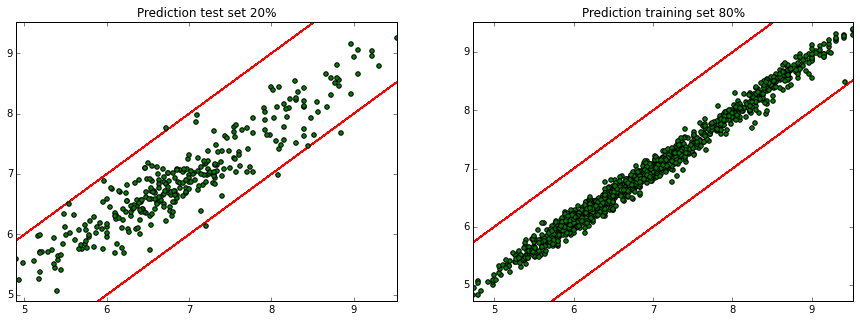

In [24]:
figure,(plt5,plt6) = pylab.subplots(1,2)
figure.set_size_inches(15,5)
plt5.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt5.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt5.scatter(y_test2,ztest2,c='green',label='test',zorder=2)
minn = np.min(np.concatenate([y_test2,ztest2],axis=0))
maxx = np.max(np.concatenate([y_test2,ztest2],axis=0))
plt5.set_ylim([minn,maxx])
plt5.set_xlim([minn,maxx])
plt5.set_title("Prediction test set 20%")

plt6.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt6.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt6.scatter(y_train2,ztest_train2,c='green',label='test',zorder=2)
plt6.set_title("Prediction training set 80%")
minn = np.min(np.concatenate([y_train2,ztest_train2],axis=0))
maxx = np.max(np.concatenate([y_train2,ztest_train2],axis=0))
plt6.set_ylim([minn,maxx])
plt6.set_xlim([minn,maxx])

# Model interpretation

Now we will use the best predictor to try and understand the data. We do so by directly interpreting the random forest (obviously these values can also be output to a text file for later interpretation.)

491


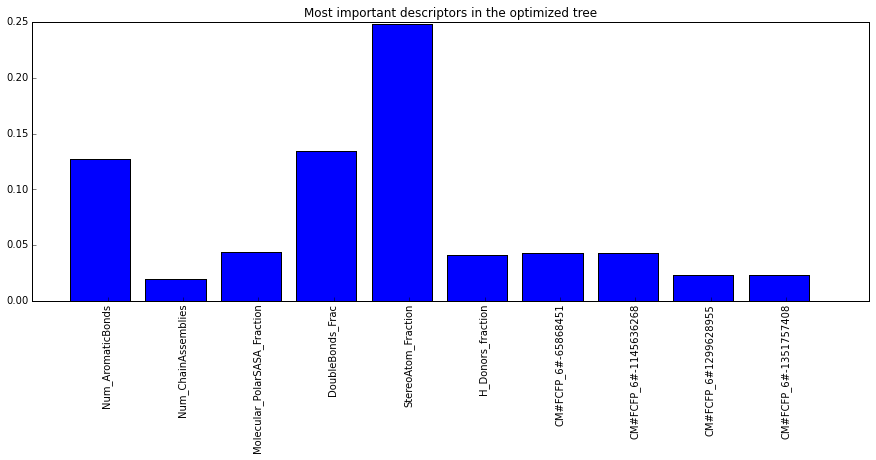

In [34]:
feat_imp = best_forest2.feature_importances_
print len(feat_imp)
fig,a = pyplot.subplots(1,1)
fig.set_size_inches(15,5)
createImportancePlot(a,list(x.columns),feat_imp,"Most important descriptors in the optimized tree")

In [26]:
print "Cross validated parameters" 
Cross_val_MSE_80 = mean_squared_error(y_train2, ztest_train2)
print "Cross_val_MSE: ", Cross_val_MSE_80
Cross_val_Exp_var_80 = explained_variance_score(y_train2, ztest_train2)
print "Cross_val_Explained_variance: " , Cross_val_Exp_var_80
Cross_val_R2_80 = r2_score(y_train2, ztest_train2)
print "Cross_val_R2_score: " , Cross_val_R2_80
print ""
print 'Externally validated parameters'
Ext_val_MSE_80 = extvmetrics2 = mean_squared_error(y_test2 , ztest2)
print "Ext_val_MSE: ", Ext_val_MSE_80 
Ext_val_Exp_var_80 =explained_variance_score(y_test2 , ztest2)
print "Ext_val_Explained_variance: " , Ext_val_Exp_var_80
Ext_val_R2_80 = r2_score(y_test2 , ztest2)
print "Ext_val_R2_score: " , Ext_val_R2_80 

Cross validated parameters
Cross_val_MSE:  0.0186526056972
Cross_val_Explained_variance:  0.981131618415
Cross_val_R2_score:  0.981117316412

Externally validated parameters
Ext_val_MSE:  0.133926620336
Ext_val_Explained_variance:  0.854971156467
Ext_val_R2_score:  0.854962233426


In [27]:
Validation2 = pd.DataFrame.from_items([ ('Parameter', ['Mean Squared Error' , 'Explained variance' , 'R2 Score']), ('Cross Validation', [Cross_val_MSE_80, Cross_val_Exp_var_80, Cross_val_R2_80 ]), ('External Validation', [Ext_val_MSE_80, Ext_val_Exp_var_80, Ext_val_R2_80 ]), ('Difference', [Ext_val_MSE_80 - Cross_val_MSE_80, Ext_val_Exp_var_80 - Cross_val_Exp_var_80, Ext_val_R2_80 - Cross_val_R2_80])])
Validation2

,Parameter,Cross Validation,External Validation,Difference
0,Mean Squared Error,0.018653,0.133927,0.115274
1,Explained variance,0.981132,0.854971,-0.126160
2,R2 Score,0.981117,0.854962,-0.126155


# Learning Curves

It can be beneficial for a better understanding of the data and the performance gained by the machine learning algorithm to create learning curves. The concept it to create several splits of your data between training and tests sets. Subsequently multiple models are trained and model performance is plotted against training set size. As this can be computationally expensive it is here included as the last section. Again, depending on the hardware this can take some time.

In [28]:
# Divide the original dataset into training 20 - testing 80, and a 50-50 set
X_traina, X_testa, y_traina, y_testa = cross_validation.train_test_split(x, y, test_size=0.95, random_state=23)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.8, random_state=23)
X_train1, X_test1, y_train1, y_test1 = cross_validation.train_test_split(x, y, test_size=0.5, random_state=23)
X_trainb, X_testb, y_trainb, y_testb = cross_validation.train_test_split(x, y, test_size=0.05, random_state=23)


In [29]:
cv = KFold(n=len(X_traina),n_folds=10,indices=False,shuffle=True)
cv_stratified = StratifiedKFold(y_traina, n_folds=5)
gs = GridSearchCV(custom_forest, params, cv=cv_stratified,verbose=1,refit=True)
gs.fit(X_traina,y_traina)
ztesta = gs.predict(X_testa)
ztest_traina = gs.predict(X_traina)
best_foresta = gs.best_estimator_

#print intermediate results to keep an eye on progress
print '5% - 95% completed' 
print 'Best score: %0.2f'%gs.best_score_
print 'Training set performance using best parameters (%s)'%gs.best_params_
best_treemodel = gs.best_estimator_
print 'Explained variance (Internal): %0.5f'%(best_foresta.score(X_traina,y_traina))
print 'MSE (Internal): %0.5f'%(mean_squared_error(y_traina,ztest_traina))
print 'Explained variance (External): %0.5f'%(best_foresta.score(X_testa,y_testa))
print 'MSE (External): %0.5f'%(mean_squared_error(y_testa,ztesta))


cv = KFold(n=len(X_train),n_folds=10,indices=False,shuffle=True)
cv_stratified = StratifiedKFold(y_train, n_folds=5)
gs = GridSearchCV(custom_forest, params, cv=cv_stratified,verbose=1,refit=True)
gs.fit(X_train,y_train)
ztest = gs.predict(X_test)
ztest_train = gs.predict(X_train)
best_forest = gs.best_estimator_

#print intermediate results to keep an eye on progress
print '20% - 80% completed' 
print 'Best score: %0.2f'%gs.best_score_
print 'Training set performance using best parameters (%s)'%gs.best_params_
best_treemodel = gs.best_estimator_
print 'Explained variance (Internal): %0.5f'%(best_forest.score(X_train,y_train))
print 'MSE (Internal): %0.5f'%(mean_squared_error(y_train,ztest_train))
print 'Explained variance (External): %0.5f'%(best_forest.score(X_test,y_test))
print 'MSE (External): %0.5f'%(mean_squared_error(y_test,ztest))

cv = KFold(n=len(X_train1),n_folds=10,indices=False,shuffle=True)
cv_stratified = StratifiedKFold(y_train1, n_folds=5)
gs = GridSearchCV(custom_forest, params, cv=cv_stratified,verbose=1,refit=True)
gs.fit(X_train1,y_train1)
ztest1 = gs.predict(X_test1)
ztest_train1 = gs.predict(X_train1)
best_forest1 = gs.best_estimator_

#print intermediate results to keep an eye on progress
print '50% - 50% completed' 
print 'Best score: %0.2f'%gs.best_score_
print 'Training set performance using best parameters (%s)'%gs.best_params_

print 'Explained variance (Internal): %0.5f'%(best_forest1.score(X_train1,y_train1))
print 'MSE (Internal): %0.5f'%(mean_squared_error(y_train1,ztest_train1))
print 'Explained variance (External): %0.5f'%(best_forest1.score(X_test1,y_test1))
print 'MSE (External): %0.5f'%(mean_squared_error(y_test1,ztest1))

cv = KFold(n=len(X_trainb),n_folds=10,indices=False,shuffle=True)
cv_stratified = StratifiedKFold(y_trainb, n_folds=5)
gs = GridSearchCV(custom_forest, params, cv=cv_stratified,verbose=1,refit=True)
gs.fit(X_trainb,y_trainb)
ztestb = gs.predict(X_testb)
ztest_trainb = gs.predict(X_trainb)
best_forestb = gs.best_estimator_

#print intermediate results to keep an eye on progress
print '95% - 5% completed' 
print 'Best score: %0.2f'%gs.best_score_
print 'Training set performance using best parameters (%s)'%gs.best_params_

print 'Explained variance (Internal): %0.5f'%(best_forestb.score(X_trainb,y_trainb))
print 'MSE (Internal): %0.5f'%(mean_squared_error(y_trainb,ztest_trainb))
print 'Explained variance (External): %0.5f'%(best_forestb.score(X_testb,y_testb))
print 'MSE (External): %0.5f'%(mean_squared_error(y_testb,ztestb))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   13.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
5% - 95% completed

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   11.3s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished



Best score: 0.57
Training set performance using best parameters ({'n_estimators': 250, 'oob_score': True})
Explained variance (Internal): 0.93829
MSE (Internal): 0.06413
Explained variance (External): 0.46237
MSE (External): 0.52245
Fitting 5 folds for each of 1 candidates, totalling 5 fits
20% - 80% completed

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:   31.4s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished



Best score: 0.77
Training set performance using best parameters ({'n_estimators': 250, 'oob_score': True})
Explained variance (Internal): 0.96808
MSE (Internal): 0.03352
Explained variance (External): 0.70020
MSE (External): 0.28624
Fitting 5 folds for each of 1 candidates, totalling 5 fits
50% - 50% completed
Best score: 0.80
Training set performance using best parameters ({'n_estimators': 250, 'oob_score': True})
Explained variance (Internal): 0.97564
MSE (Internal): 0.02439
Explained variance (External): 0.80709

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished



MSE (External): 0.18306
Fitting 5 folds for each of 1 candidates, totalling 5 fits
95% - 5% completed
Best score: 0.86
Training set performance using best parameters ({'n_estimators': 250, 'oob_score': True})
Explained variance (Internal): 0.98267
MSE (Internal): 0.01718
Explained variance (External): 0.75705
MSE (External): 0.16002


(4.7300000000000004, 9.5199999999999996)

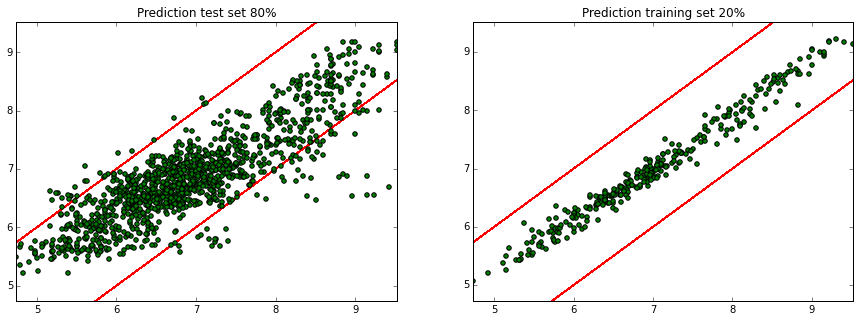

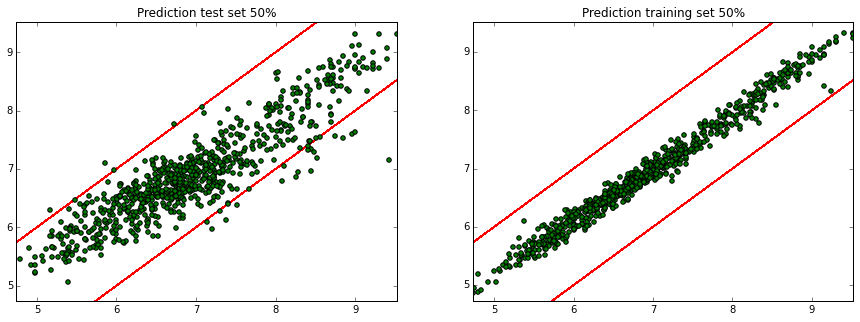

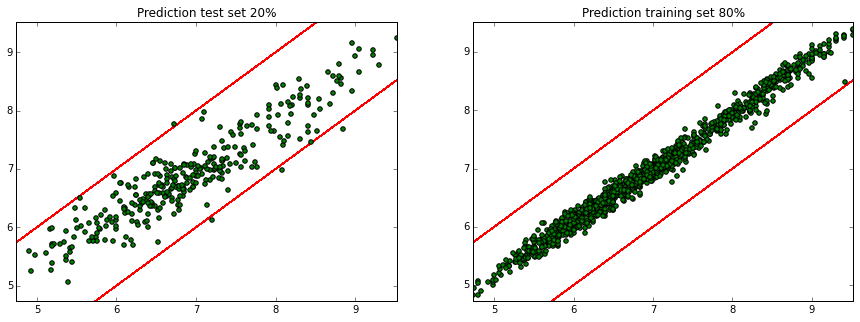

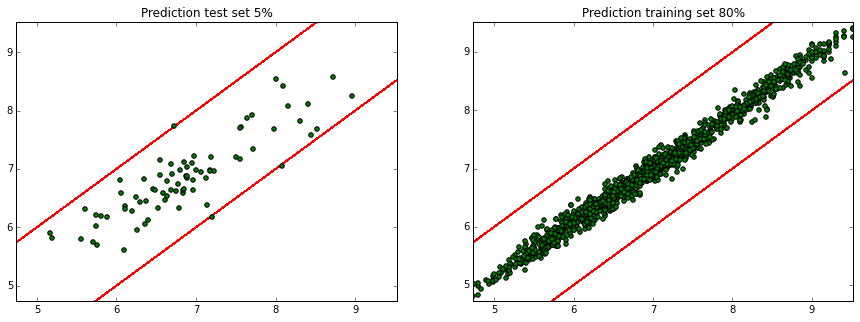

In [30]:
#create measured vs predicted plots
#plt.xkcd()
figure,(plt1,plt2) = pylab.subplots(1,2)
figure.set_size_inches(15,5)
plt1.plot(x-1,x,c='red',linewidth=1,zorder=1)
plt1.plot(x+1,x,c='red',linewidth=1,zorder=1)
plt1.scatter(y_test,ztest,c='green',label='test',zorder=2)
minn = np.min(np.concatenate([y_test,ztest],axis=0))
maxx = np.max(np.concatenate([y_test,ztest],axis=0))
plt1.set_ylim([minn,maxx])
plt1.set_xlim([minn,maxx])
plt1.set_title("Prediction test set 80%")

plt2.plot(x-1,x,c='red',linewidth=1,zorder=1)
plt2.plot(x+1,x,c='red',linewidth=1,zorder=1)
plt2.scatter(y_train,ztest_train,c='green',label='test',zorder=2)
plt2.set_title("Prediction training set 20%")
minn = np.min(np.concatenate([y_train,ztest_train],axis=0))
maxx = np.max(np.concatenate([y_train,ztest_train],axis=0))
plt2.set_ylim([minn,maxx])
plt2.set_xlim([minn,maxx])

figure,(plt3,plt4) = pylab.subplots(1,2)
figure.set_size_inches(15,5)
plt3.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt3.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt3.scatter(y_test1,ztest1,c='green',label='test',zorder=2)
minn = np.min(np.concatenate([y_test,ztest],axis=0))
maxx = np.max(np.concatenate([y_test,ztest],axis=0))
plt3.set_ylim([minn,maxx])
plt3.set_xlim([minn,maxx])
plt3.set_title("Prediction test set 50%")

plt4.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt4.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt4.scatter(y_train1,ztest_train1,c='green',label='test',zorder=2)
plt4.set_title("Prediction training set 50%")
minn = np.min(np.concatenate([y_train,ztest_train],axis=0))
maxx = np.max(np.concatenate([y_train,ztest_train],axis=0))
plt4.set_ylim([minn,maxx])
plt4.set_xlim([minn,maxx])


figure,(plt5,plt6) = pylab.subplots(1,2)
figure.set_size_inches(15,5)
plt5.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt5.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt5.scatter(y_test2,ztest2,c='green',label='test',zorder=2)
minn = np.min(np.concatenate([y_test,ztest],axis=0))
maxx = np.max(np.concatenate([y_test,ztest],axis=0))
plt5.set_ylim([minn,maxx])
plt5.set_xlim([minn,maxx])
plt5.set_title("Prediction test set 20%")

plt6.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt6.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt6.scatter(y_train2,ztest_train2,c='green',label='test',zorder=2)
plt6.set_title("Prediction training set 80%")
minn = np.min(np.concatenate([y_train,ztest_train],axis=0))
maxx = np.max(np.concatenate([y_train,ztest_train],axis=0))
plt6.set_ylim([minn,maxx])
plt6.set_xlim([minn,maxx])

figure,(plt7,plt8) = pylab.subplots(1,2)
figure.set_size_inches(15,5)
plt7.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt7.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt7.scatter(y_testb,ztestb,c='green',label='test',zorder=2)
minn = np.min(np.concatenate([y_test,ztest],axis=0))
maxx = np.max(np.concatenate([y_test,ztest],axis=0))
plt7.set_ylim([minn,maxx])
plt7.set_xlim([minn,maxx])
plt7.set_title("Prediction test set 5%")

plt8.plot(x-1,x,c='red', linewidth=1,zorder=1)
plt8.plot(x+1,x,c='red', linewidth=1,zorder=1)
plt8.scatter(y_trainb,ztest_trainb,c='green',label='test',zorder=2)
plt8.set_title("Prediction training set 80%")
minn = np.min(np.concatenate([y_train,ztest_train],axis=0))
maxx = np.max(np.concatenate([y_train,ztest_train],axis=0))
plt8.set_ylim([minn,maxx])
plt8.set_xlim([minn,maxx])

In [31]:
print '5%-95%'
print "Cross validated parameters" 
Cross_val_MSE_05 = mean_squared_error(y_traina, ztest_traina)
print "Cross_val_MSE: ", Cross_val_MSE_05
Cross_val_R2_05 = r2_score(y_traina, ztest_traina)
print "Cross_val_R2_score: " , Cross_val_R2_05
print ""
print 'Externally validated parameters'
Ext_val_MSE_05 = extvmetrics2 = mean_squared_error(y_testa , ztesta)
print "Ext_val_MSE: ", Ext_val_MSE_05 
Ext_val_R2_05 = r2_score(y_testa , ztesta)
print "Ext_val_R2_score: " , Ext_val_R2_05 
print ''
print ''
print '20%-80%'
Cross_val_MSE_20 = mean_squared_error(y_train, ztest_train)
print "Cross_val_MSE: ", Cross_val_MSE_20
Cross_val_Exp_var_20 = explained_variance_score(y_train, ztest_train)
print "Cross_val_Explained_variance: " , Cross_val_Exp_var_20
Cross_val_R2_20 = r2_score(y_train, ztest_train)
print "Cross_val_R2_score: " , Cross_val_R2_20
print ''
Ext_val_MSE_20 = mean_squared_error(y_test , ztest)
print "Ext_val_MSE: ", Ext_val_MSE_20
Ext_val_Exp_var_20 = explained_variance_score(y_test , ztest)
print "Ext_val_Explained_variance: " , Ext_val_Exp_var_20
Ext_val_R2_20 = r2_score(y_test , ztest)
print "Ext_val_R2_score: " , Ext_val_R2_20 
print ''
print ''
print '50%-50%'
Cross_val_MSE_50 = mean_squared_error(y_train1, ztest_train1)
print "Cross_val_MSE: ", Cross_val_MSE_50 
Cross_val_Exp_var_50 = explained_variance_score(y_train1, ztest_train1)
print "Cross_val_Explained_variance: " , Cross_val_Exp_var_50
Cross_val_R2_50 = r2_score(y_train1, ztest_train1)
print "Cross_val_R2_score: " , Cross_val_R2_50 
print''
Ext_val_MSE_50 = mean_squared_error(y_test1 , ztest1)
print "Ext_val_MSE: ", Ext_val_MSE_20
Ext_val_Exp_var_50 = explained_variance_score(y_test1 , ztest1)
print "Ext_val_Explained_variance: " ,Ext_val_Exp_var_50
Ext_val_R2_50 = r2_score(y_test1 , ztest1)
print "Ext_val_R2_score: " , Ext_val_R2_50
print ''
print ''
print '95%-5%'
print "Cross validated parameters" 
Cross_val_MSE_95 = mean_squared_error(y_trainb, ztest_trainb)
print "Cross_val_MSE: ", Cross_val_MSE_95
Cross_val_R2_95 = r2_score(y_trainb, ztest_trainb)
print "Cross_val_R2_score: " , Cross_val_R2_95
print ""
print 'Externally validated parameters'
Ext_val_MSE_95 = extvmetrics2 = mean_squared_error(y_testb , ztestb)
print "Ext_val_MSE: ", Ext_val_MSE_95 
Ext_val_R2_95 = r2_score(y_testb , ztestb)
print "Ext_val_R2_score: " , Ext_val_R2_95 

5%-95%
Cross validated parameters
Cross_val_MSE:  0.0641316414154
Cross_val_R2_score:  0.938287564173

Externally validated parameters
Ext_val_MSE:  0.522451463992
Ext_val_R2_score:  0.462368122942


20%-80%
Cross_val_MSE:  0.0335233862083
Cross_val_Explained_variance:  0.968090406015
Cross_val_R2_score:  0.968082904151

Ext_val_MSE:  0.28624077071
Ext_val_Explained_variance:  0.704093082002
Ext_val_R2_score:  0.700198727591


50%-50%
Cross_val_MSE:  0.0243897386524
Cross_val_Explained_variance:  0.975680673534
Cross_val_R2_score:  0.975644950266

Ext_val_MSE:  0.28624077071
Ext_val_Explained_variance:  0.808713471315
Ext_val_R2_score:  0.807093420953


95%-5%
Cross validated parameters
Cross_val_MSE:  0.0171829381049
Cross_val_R2_score:  0.982673113644

Externally validated parameters
Ext_val_MSE:  0.160017686744
Ext_val_R2_score:  0.757045705184


In [32]:
#generation of the arrays
learning_x = np.array([5, 20, 50, 80, 95])
plot_ext_rmse = np.array([Ext_val_MSE_05 , Ext_val_MSE_20 , Ext_val_MSE_50 , Ext_val_MSE_80 , Ext_val_MSE_95])
plot_cross_rmse = np.array([Cross_val_MSE_05 , Cross_val_MSE_20 , Cross_val_MSE_50 , Cross_val_MSE_80 , Cross_val_MSE_95])

plot_ext_r2 = np.array([Ext_val_R2_05 , Ext_val_R2_20 , Ext_val_R2_50 , Ext_val_R2_80 , Ext_val_R2_95])
plot_cross_r2 = np.array([Cross_val_R2_05 , Cross_val_R2_20 , Cross_val_R2_50 , Cross_val_R2_80 , Cross_val_R2_95])

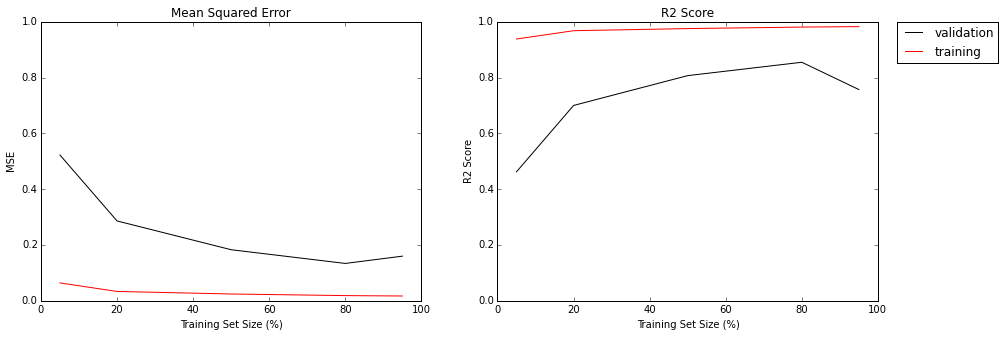

In [33]:
#the actual plot
figure,(plt1,plt2) = pylab.subplots(1,2)
figure.set_size_inches(15,5)
plt1.set_ylim([0, 1])
plt1.set_xlim([0, 100])
plt1.set_title('Mean Squared Error')
plt1.plot(learning_x,plot_ext_rmse,c='black',linewidth=1,zorder=1)
plt1.plot(learning_x,plot_cross_rmse,c='red',linewidth=1,zorder=1)
plt1.set_xlabel('Training Set Size (%)')
plt1.set_ylabel('MSE')

plt2.set_ylim([0, 1])
plt2.set_xlim([0, 100])
plt2.set_title('R2 Score')
plt2.plot(learning_x,plot_ext_r2,c='black',linewidth=1,zorder=1, label='validation')
plt2.plot(learning_x,plot_cross_r2,c='red',linewidth=1,zorder=1, label='training')
plt2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt2.set_xlabel('Training Set Size (%)')
plt2.set_ylabel('R2 Score')

plt.show()

Interestingly the performance appears to go down for the 95% training - 5% validaiton split. This is however caused by the much smaller sample. The influence of the outliers on the scores is relatively rather large. This effect will not be so pronounced when using a larger data set than the here used 1500 datapoints. 